# Earlier-later experiment

Dec 2024

Sanity check, plugging in numbers for each of the trials/conditions

Participants choose between two utterances that are both understood by the audience: an earlier longer utterance, or a later shorter utterance. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from memo import memo
import jax
import jax.numpy as jnp
from jax import lax
from enum import IntEnum

Choosing between an earlier+longer and a later+shorter utterance

The conditions: 
- refer + either 
- refer + one
- social + one

In [2]:
class Utterances(IntEnum):
    Earlier = 0
    Later = 1


class Audiences(IntEnum):
    Ingroup = 0
    Naive = 1


class TangramTypes(IntEnum):
    Shared = 0
    NonShared = 1


@jax.jit
def is_ingroup(audience):
    return audience == Audiences.Ingroup


@jax.jit
def base_info(tangram_type, audience, utt):
    naive_info_shared = jnp.array(
        [0.8, 0.8]
    )  # for 'shared' tangram type, the later utterance has higher referential informativity
    naive_info_non_shared = jnp.array([0.8, 0.6])
    ingroup_info = jnp.array(
        [0.85, 0.85]
    )  # later utterance has higher referential informativity to ingroup

    naive_info = lax.cond(
        tangram_type == TangramTypes.Shared,
        lambda _: naive_info_shared,
        lambda _: naive_info_non_shared,
        operand=None,
    )

    info = lax.cond(
        audience == Audiences.Naive,
        lambda _: naive_info,
        lambda _: ingroup_info,
        operand=None,
    )
    return info[utt]


@jax.jit
def utt_length(utt):
    return jnp.array([15, 2])[utt]


@jax.jit
def social_info(utt):
    # later utterance has higher social informativity
    return jnp.array([0.1, 0.6])[utt]

In [3]:
# type: ignore
@memo
def S_certain[u: Utterances, audience: Audiences](tangram_type, alpha, w_r, w_s, w_c):
    cast: [speaker]
    speaker: chooses(audience in Audiences, wpp=is_ingroup(audience))
    speaker: chooses(
        u in Utterances,
        wpp=exp(
            alpha * (w_r * base_info(tangram_type, audience, u) + w_s * social_info(u) - w_c * utt_length(u))
        ),
    )
    return Pr[speaker.u == u]


@memo
def S_uncertain[u: Utterances, audience: Audiences](tangram_type, alpha, w_r, w_s, w_c):
    cast: [speaker]
    speaker: chooses(audience in Audiences, wpp=1)
    speaker: chooses(
        u in Utterances,
        wpp=exp(
            alpha * (w_r * base_info(tangram_type, audience, u) + w_s * social_info(u) - w_c * utt_length(u))
        ),
    )
    return Pr[speaker.u == u]

Generate predictions

In [4]:
alpha = 2 
df = pd.DataFrame(columns=["condition", "tangram_type", "earlier"])
df = pd.concat([
    df, 
    pd.DataFrame({
        "condition": "refer+either",
        "tangram_type": "shared",
        "earlier": np.array(S_uncertain(tangram_type=TangramTypes.Shared, alpha=alpha, w_r=1, w_s=0, w_c=0.01))[0]
    }), 
    pd.DataFrame({
        "condition": "refer+either",
        "tangram_type": "group-specific",
        "earlier": np.array(S_uncertain(tangram_type=TangramTypes.NonShared, alpha=alpha, w_r=1, w_s=0, w_c=0.01))[0]
    }),
    pd.DataFrame({
        "condition": "refer+one",
        "tangram_type": "shared",
        "earlier": np.array(S_certain(tangram_type=TangramTypes.Shared, alpha=alpha, w_r=1, w_s=0.5, w_c=0.01))[0]
    }),
    pd.DataFrame({
        "condition": "refer+one",
        "tangram_type": "group-specific",
        "earlier": np.array(S_certain(tangram_type=TangramTypes.NonShared, alpha=alpha, w_r=1, w_s=0.5, w_c=0.01))[0]
    }),
    pd.DataFrame({
        "condition": "social+one",
        "tangram_type": "shared",
        "earlier": np.array(S_certain(tangram_type=TangramTypes.Shared, alpha=alpha, w_r=0, w_s=1, w_c=0.01))[0]
    }),
    pd.DataFrame({
        "condition": "social+one",
        "tangram_type": "group-specific",
        "earlier": np.array(S_certain(tangram_type=TangramTypes.NonShared, alpha=alpha, w_r=0, w_s=1, w_c=0.01))[0]
    })
])

/var/folders/fc/814yph2s11jgjvdqqz2x9w0c0000gn/T/ipykernel_21602/4041458629.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([


In [5]:
df

,condition,tangram_type,earlier
0,refer+either,shared,0.435364
0,refer+either,group-specific,0.485153
0,refer+one,shared,0.318646
0,refer+one,group-specific,0.318646
0,social+one,shared,0.220974
0,social+one,group-specific,0.220974


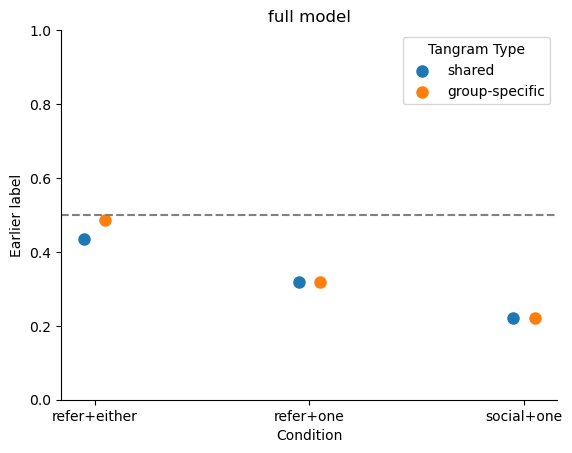

In [6]:
fig, ax = plt.subplots()

offset = 0.1
unique_conditions = sorted(df['condition'].unique())
x_positions = {cond: i for i, cond in enumerate(unique_conditions)}

unique_tangram_types = sorted(df['tangram_type'].unique(), reverse=True)

for i, key in enumerate(unique_tangram_types):
    grp = df[df['tangram_type'] == key]
    # Offset x positions for each tangram_type
    x_vals = [x_positions[cond] + i * offset - (len(unique_tangram_types) - 1) * offset / 2
              for cond in grp['condition']]
    ax.scatter(x_vals, grp['earlier'], label=key, s=64)

ax.axhline(0.5, color="gray", linestyle="--")
ax.set_ylim(0, 1)
ax.legend(title='Tangram Type')
ax.set_xticks(range(len(unique_conditions)))
ax.set_xticklabels(unique_conditions)
ax.set_xlabel('Condition')
ax.set_ylabel('Earlier label')
plt.title("full model")
sns.despine()
plt.show()

## Refer only or social only

Refer only: no social utility possible

In [7]:
alpha = 2 
df = pd.DataFrame(columns=["condition", "tangram_type", "earlier"])
df = pd.concat([
    df, 
    pd.DataFrame({
        "condition": "refer+either",
        "tangram_type": "shared",
        "earlier": np.array(S_uncertain(tangram_type=TangramTypes.Shared, alpha=alpha, w_r=1, w_s=0, w_c=0.01))[0]
    }), 
    pd.DataFrame({
        "condition": "refer+either",
        "tangram_type": "group-specific",
        "earlier": np.array(S_uncertain(tangram_type=TangramTypes.NonShared, alpha=alpha, w_r=1, w_s=0, w_c=0.01))[0]
    }),
    pd.DataFrame({
        "condition": "refer+one",
        "tangram_type": "shared",
        "earlier": np.array(S_certain(tangram_type=TangramTypes.Shared, alpha=alpha, w_r=1, w_s=0, w_c=0.01))[0]
    }),
    pd.DataFrame({
        "condition": "refer+one",
        "tangram_type": "group-specific",
        "earlier": np.array(S_certain(tangram_type=TangramTypes.NonShared, alpha=alpha, w_r=1, w_s=0, w_c=0.01))[0]
    }),
    pd.DataFrame({
        "condition": "social+one",
        "tangram_type": "shared",
        "earlier": np.array(S_certain(tangram_type=TangramTypes.Shared, alpha=alpha, w_r=0, w_s=0, w_c=0.01))[0]
    }),
    pd.DataFrame({
        "condition": "social+one",
        "tangram_type": "group-specific",
        "earlier": np.array(S_certain(tangram_type=TangramTypes.NonShared, alpha=alpha, w_r=0, w_s=0, w_c=0.01))[0]
    })
])

/var/folders/fc/814yph2s11jgjvdqqz2x9w0c0000gn/T/ipykernel_21602/2036686450.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([


In [8]:
df

,condition,tangram_type,earlier
0,refer+either,shared,0.435364
0,refer+either,group-specific,0.485153
0,refer+one,shared,0.435364
0,refer+one,group-specific,0.435364
0,social+one,shared,0.435364
0,social+one,group-specific,0.435364


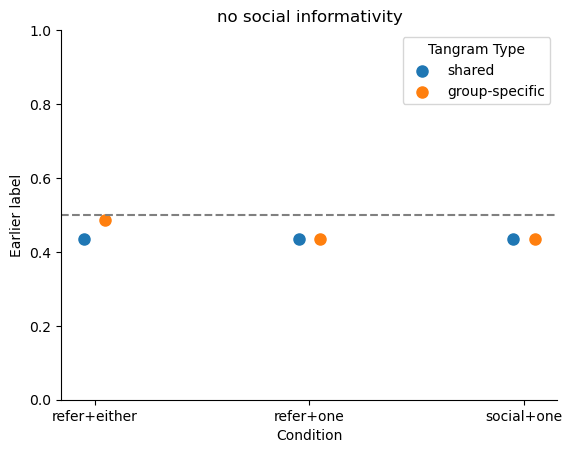

In [9]:
fig, ax = plt.subplots()

offset = 0.1
unique_conditions = sorted(df['condition'].unique())
x_positions = {cond: i for i, cond in enumerate(unique_conditions)}

unique_tangram_types = sorted(df['tangram_type'].unique(), reverse=True)

for i, key in enumerate(unique_tangram_types):
    grp = df[df['tangram_type'] == key]
    # Offset x positions for each tangram_type
    x_vals = [x_positions[cond] + i * offset - (len(unique_tangram_types) - 1) * offset / 2
              for cond in grp['condition']]
    ax.scatter(x_vals, grp['earlier'], label=key, s=64)

ax.axhline(0.5, color="gray", linestyle="--")
ax.set_ylim(0, 1)
ax.legend(title='Tangram Type')
ax.set_xticks(range(len(unique_conditions)))
ax.set_xticklabels(unique_conditions)
ax.set_xlabel('Condition')
ax.set_ylabel('Earlier label')
plt.title("no social informativity")
sns.despine()
plt.show()

social only

In [10]:
alpha = 2 
df = pd.DataFrame(columns=["condition", "tangram_type", "earlier"])
df = pd.concat([
    df, 
    pd.DataFrame({
        "condition": "refer+either",
        "tangram_type": "shared",
        "earlier": np.array(S_uncertain(tangram_type=TangramTypes.Shared, alpha=alpha, w_r=0, w_s=0, w_c=0.01))[0]
    }), 
    pd.DataFrame({
        "condition": "refer+either",
        "tangram_type": "group-specific",
        "earlier": np.array(S_uncertain(tangram_type=TangramTypes.NonShared, alpha=alpha, w_r=0, w_s=0, w_c=0.01))[0]
    }),
    pd.DataFrame({
        "condition": "refer+one",
        "tangram_type": "shared",
        "earlier": np.array(S_certain(tangram_type=TangramTypes.Shared, alpha=alpha, w_r=0, w_s=0.5, w_c=0.01))[0]
    }),
    pd.DataFrame({
        "condition": "refer+one",
        "tangram_type": "group-specific",
        "earlier": np.array(S_certain(tangram_type=TangramTypes.NonShared, alpha=alpha, w_r=0, w_s=0.5, w_c=0.01))[0]
    }),
    pd.DataFrame({
        "condition": "social+one",
        "tangram_type": "shared",
        "earlier": np.array(S_certain(tangram_type=TangramTypes.Shared, alpha=alpha, w_r=0, w_s=1, w_c=0.01))[0]
    }),
    pd.DataFrame({
        "condition": "social+one",
        "tangram_type": "group-specific",
        "earlier": np.array(S_certain(tangram_type=TangramTypes.NonShared, alpha=alpha, w_r=0, w_s=1, w_c=0.01))[0]
    })
])

/var/folders/fc/814yph2s11jgjvdqqz2x9w0c0000gn/T/ipykernel_21602/2794792392.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([


In [11]:
df

,condition,tangram_type,earlier
0,refer+either,shared,0.435364
0,refer+either,group-specific,0.435364
0,refer+one,shared,0.318646
0,refer+one,group-specific,0.318646
0,social+one,shared,0.220974
0,social+one,group-specific,0.220974


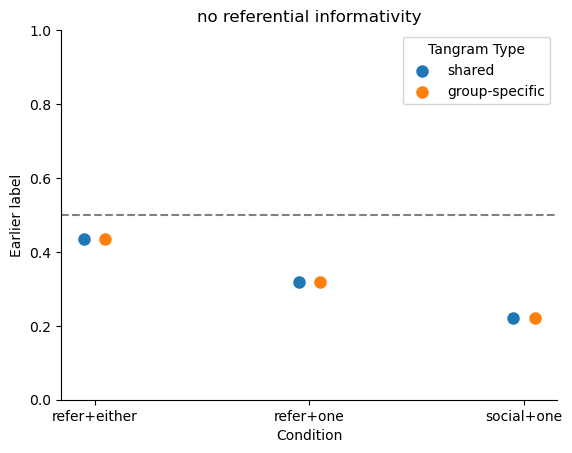

In [12]:
fig, ax = plt.subplots()

offset = 0.1
unique_conditions = sorted(df['condition'].unique())
x_positions = {cond: i for i, cond in enumerate(unique_conditions)}

unique_tangram_types = sorted(df['tangram_type'].unique(), reverse=True)

for i, key in enumerate(unique_tangram_types):
    grp = df[df['tangram_type'] == key]
    # Offset x positions for each tangram_type
    x_vals = [x_positions[cond] + i * offset - (len(unique_tangram_types) - 1) * offset / 2
              for cond in grp['condition']]
    ax.scatter(x_vals, grp['earlier'], label=key, s=64)

ax.axhline(0.5, color="gray", linestyle="--")
ax.set_ylim(0, 1)
ax.legend(title='Tangram Type')
ax.set_xticks(range(len(unique_conditions)))
ax.set_xticklabels(unique_conditions)
ax.set_xlabel('Condition')
ax.set_ylabel('Earlier label')
plt.title("no referential informativity")
sns.despine()
plt.show()